In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.3 MB/s eta 0:00:00


Epoch 000, Loss: 1.3863, Val Acc: 0.3333
Epoch 005, Loss: 1.3186, Val Acc: 0.3333
Epoch 010, Loss: 1.2759, Val Acc: 0.3333
Epoch 015, Loss: 1.2279, Val Acc: 0.3333
Epoch 020, Loss: 1.1732, Val Acc: 0.3333
Epoch 025, Loss: 1.1047, Val Acc: 0.3333
Epoch 030, Loss: 1.0243, Val Acc: 0.3333
Epoch 035, Loss: 0.9259, Val Acc: 0.3333
Epoch 040, Loss: 0.8090, Val Acc: 0.3333
Epoch 045, Loss: 0.6786, Val Acc: 0.3333


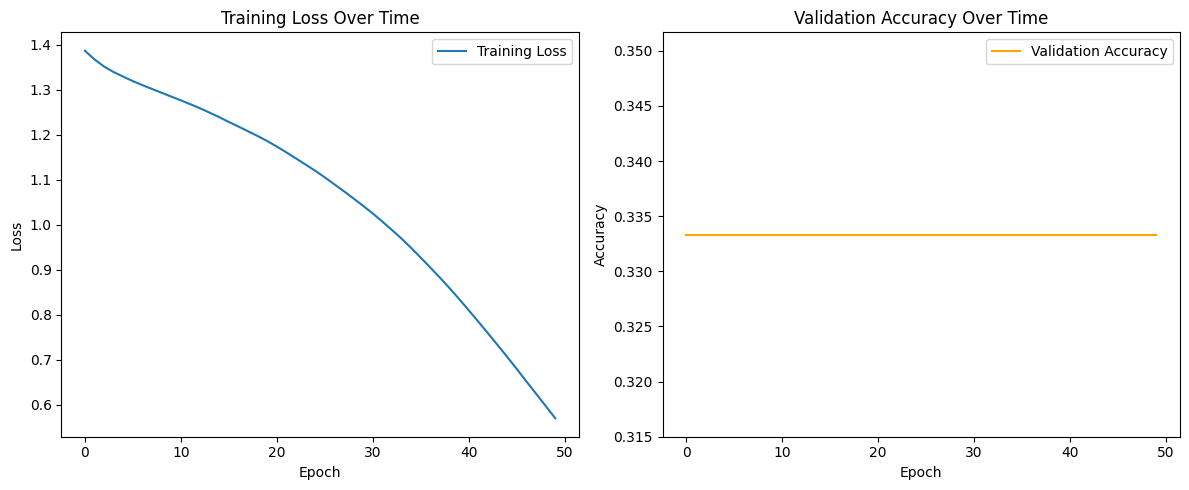

Test Accuracy: 0.0000


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import accuracy_score
from torch_geometric.utils import from_networkx

# Генерация синтетического графа
def generate_synthetic_graph(num_nodes=100, num_classes=4):
    G = nx.karate_club_graph()
    # Увеличим граф для наглядности
    G = nx.disjoint_union(G, G)
    G = nx.disjoint_union(G, G)

    # Создаем признаки вершин и метки классов
    features = np.random.randn(len(G), 10)  # 10 признаков на вершину
    labels = np.random.randint(0, num_classes, len(G))

    return G, features, labels

# Функция для выбора вершин (на основе степени)
def select_nodes(G, k=20):
    degrees = dict(G.degree())
    sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
    selected = [node[0] for node in sorted_nodes[:k]]
    return selected

# Функция для сборки окрестностей (BFS)
def assemble_neighborhoods(G, selected_nodes, w=10):
    neighborhoods = []
    for node in selected_nodes:
        neighbors = list(nx.bfs_tree(G, node, depth_limit=2).nodes())
        if len(neighbors) > w:
            neighbors = neighbors[:w]
        neighborhoods.append(neighbors)
    return neighborhoods

# Функция нормализации (простая версия)
def normalize_graph(G, neighborhood):
    # Простая нормализация по степени вершин
    degrees = [G.degree(node) for node in neighborhood]
    normalized = [x for _, x in sorted(zip(degrees, neighborhood), reverse=True)]
    return normalized

# Функция для создания тензоров
def create_tensors(G, features, neighborhoods, w=10, feature_dim=10):
    num_nodes = len(neighborhoods)
    tensors = torch.zeros((num_nodes, w, feature_dim))

    for i, neighborhood in enumerate(neighborhoods):
        normalized = normalize_graph(G, neighborhood)
        for j, node in enumerate(normalized):
            if j < w:
                tensors[i, j] = torch.tensor(features[node])

    return tensors

# Модель PSCN
class PSCN(nn.Module):
    def __init__(self, feature_dim=10, hidden_dim=32, output_dim=4, w=10):
        super(PSCN, self).__init__()
        self.w = w

        # Сверточные слои
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3))

        # Вычисление размера после сверток
        conv_out_size = self._get_conv_output_size(feature_dim, w)

        # Полносвязные слои
        self.fc1 = nn.Linear(conv_out_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def _get_conv_output_size(self, feature_dim, w):
        # Эмуляция прохода через сверточные слои для определения размера
        x = torch.zeros(1, 1, w, feature_dim)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        return x.view(1, -1).shape[1]

    def forward(self, x):
        # Добавляем размерность канала
        x = x.unsqueeze(1)

        # Сверточные слои
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        # Полносвязные слои
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

# Визуализация графа
"""def visualize_graph(G, labels, node_size=50):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=labels, cmap=plt.cm.tab10,
            node_size=node_size, with_labels=False)
    plt.title("Graph Structure with Node Classes")
    plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.tab10),
                 label="Node Class")
    plt.show()"""

# Визуализация обучения
def plot_training(epochs, train_losses, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Основной код
def main():
    # Параметры
    feature_dim = 10
    hidden_dim = 32
    output_dim = 4
    w = 10  # Размер окрестности
    k = 20  # Количество выбираемых вершин
    epochs = 50
    lr = 0.001

    # Генерация данных
    G, features, labels = generate_synthetic_graph(num_nodes=100, num_classes=output_dim)
   # visualize_graph(G, labels)

    # PATCHY-SAN обработка
    selected_nodes = select_nodes(G, k=k)
    neighborhoods = assemble_neighborhoods(G, selected_nodes, w=w)
    tensors = create_tensors(G, features, neighborhoods, w=w, feature_dim=feature_dim)

    # Преобразование меток для выбранных вершин
    selected_labels = torch.tensor([labels[node] for node in selected_nodes], dtype=torch.long)

    # Разделение на train/val/test
    num_samples = len(selected_nodes)
    indices = np.random.permutation(num_samples)
    train_idx = indices[:int(0.7*num_samples)]
    val_idx = indices[int(0.7*num_samples):int(0.85*num_samples)]
    test_idx = indices[int(0.85*num_samples):]

    # Модель и оптимизатор
    model = PSCN(feature_dim, hidden_dim, output_dim, w)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.NLLLoss()

    # Обучение
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        out = model(tensors[train_idx])
        loss = criterion(out, selected_labels[train_idx])
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Валидация
        model.eval()
        with torch.no_grad():
            pred = model(tensors[val_idx]).argmax(dim=1)
            val_acc = accuracy_score(selected_labels[val_idx].numpy(), pred.numpy())
            val_accuracies.append(val_acc)

        if epoch % 5 == 0:
            print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')

    # Визуализация обучения
    plot_training(epochs, train_losses, val_accuracies)

    # Тестирование
    model.eval()
    with torch.no_grad():
        pred = model(tensors[test_idx]).argmax(dim=1)
        test_acc = accuracy_score(selected_labels[test_idx].numpy(), pred.numpy())
        print(f'Test Accuracy: {test_acc:.4f}')

    # Визуализация предсказаний для выбранных вершин
    selected_labels_vis = np.zeros(len(G))
    #selected_labels_vis[selected_nodes] = pred.numpy() + 1  # +1 для визуального отличия
   # visualize_graph(G, selected_labels_vis, node_size=50)

if __name__ == '__main__':
    main()